<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px; width: 180px">
            <img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo">
        </td>
        <td style="width: 100%">
            <div style="width: 100%; text-align:right"><font style="font-size:38px"><b>Softwaredesign</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b>WS 2023</b></font></div>
        </td>
    </tr>
</table>

---

# Auswertung eines Windkanalversuchs

Es wurde ein Windkanalversuch durchgeführt um den Luftwiderstand eines neuentwickelten Motorrades im Modellversuch zu bestimmen. Dazu wurde das Modell des Motorrades in den Windkanal gestellt und bei verschiedenen Windgeschwindigkeiten mit einem Kraft-Momenten-Sensor die aus dem Luftwiderstand resultierenden Kräfte und Momente gemessen.

<img style="width:45%" src="motorrad_in_windkanal.jpeg"></img> [Pillei 2022]

Solch eine Messung wurde für eine Dauer von $5\,\mathrm{s}$ durchgeführt und enthält wegen der verwendeten Abtastrate in Summe 1500 Messpunkte.

Die Messwerte sind in der Datei `drag_data.csv` gespeichert. Die Datei enthält folgende Spalten:

| Spalte | Größe | Einheit |
|:------:|:-----:|:-------:|
| 1 | $t$   | $\mathrm{s}$ |
| 2 | $F_x$ | $\mathrm{N}$ |
| 3 | $F_y$ | $\mathrm{N}$ |
| 4 | $F_z$ | $\mathrm{N}$ |
| 5 | $M_x$ | $\mathrm{Nm}$ |
| 6 | $M_y$ | $\mathrm{Nm}$ |
| 7 | $M_z$ | $\mathrm{Nm}$ |

Weiters ist bekannt, dass die Windgeschwindigkeit $v = 60\,\frac{\mathrm{km}}{\mathrm{h}}$ beträgt.
Aus dem CAD-Modell des Motorrad-Modells ist bekannt, dass die Stirnfläche $A = 0.0876\,\mathrm{m}^2$ beträgt.

<img style="width:45%" src="motorrad_lda_plot.jpg"></img> [Pillei 2022]

In dieser Auswertung soll der Strömungswiderstandskoeffizient $c_w$ aus den gemessenen Daten bestimmt werden.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%matplotlib widget
%matplotlib inline

### 1. Laden der Daten aus der bereitgestellten CSV-Datei

Sie müssen die bereitgestellte Datei `drag_data.csv` laden und die jeweiligen benötigten Daten extrahieren.
Wählen Sie eine der beiden Varianten (`numpy` Array oder `pandas` DataFrame) aus.

In [16]:
# Wählen Sie eine der Varianten für den Datenimport aus
data = np.loadtxt("drag_data.csv", delimiter=",", skiprows=0, dtype=float) # Import as Numpy Array
# data = pd.read_csv('drag_data.csv', sep=',', names=['t', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']) # Import as Pandas DataFrame

# Lösung einfügen...
# Einzelne Größen aus gesamten Datensatz extrahieren
t  = data[:, 0]
Fx = data[:, 1]
Fy = data[:, 2]
Fz = data[:, 3]
Mx = data[:, 4]
My = data[:, 5]
Mz = data[:, 6]

### Erste Visualisierung der Daten

Um einen ersten Eindruck von den Daten zu bekommen, sollen Sie die Daten in einem Diagramm visualisieren.
Stellen Sie dazu die gemessenen Kräfte $F_x$, $F_y$ und $F_z$ über der Zeit $t$ im linken `subplot` und die gemessenen Momente $M_x$, $M_y$ und $M_z$ über der Zeit $t$ im rechten `subplot` dar.

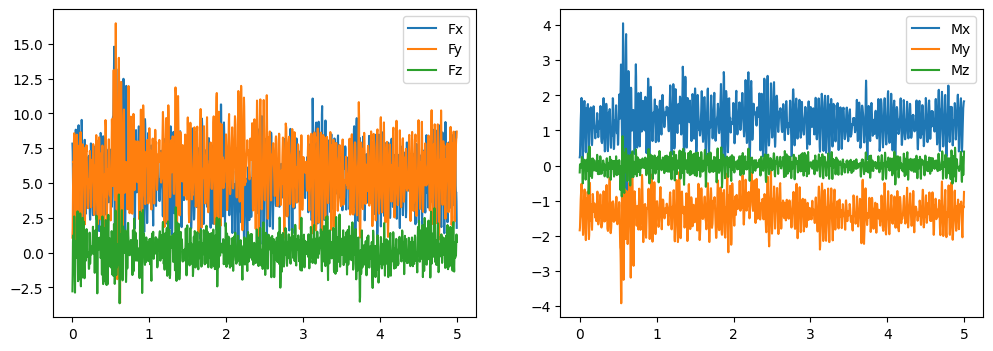

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

# Lösung einfügen...
ax1.plot(t, Fx, label="Fx")
ax1.plot(t, Fy, label="Fy")
ax1.plot(t, Fz, label="Fz")
ax1.legend()
ax2.plot(t, Mx, label="Mx")
ax2.plot(t, My, label="My")
ax2.plot(t, Mz, label="Mz")
ax2.legend()

plt.show()

### Messdaten aus dem Koordinatensystem des Sensors in jenes des Windkanals transformieren

Das Koordinatensystem in dem die Messdaten gespeichert sind, ist jenes des Kraft-Momenten-Sensors. Dieses Koordinatensystem ist in der folgenden Abbildung dargestellt.
<img style="width:20%" src="kms_koordinatensystem_windkanal.png"></img>

Als Referenz zum Windkanals dient das Koordinatensystem in der rechten unteren Ecke der Abbildung.

Für die weitere Analyse müssen die Daten jedoch so transformiert (gedreht) werden, dass sie im Koordinatensystem des Windkanals vorliegen. Dies bedeutet, dass eine der Achsen des Koordinatensystems des Windkanals (für gewöhnlich die X-Richtung) mit der Windrichtung übereinstimmt.

In der Mathematikvorlesung haben Sie bereits behandelt wie so eine Drehung eines Vektors oder eines Koordinatensystems mit Hilfe einer Rotationsmatrix durchgeführt werden kann. 

In [32]:
# Lösung einfügen...
angle = np.radians(-45)
R_z = np.array([
    [np.cos(angle), -np.sin(angle), 0],
    [np.sin(angle),  np.cos(angle), 0],
    [0,              0,             1]
])

Fxyz = np.array((Fx, Fy, Fz)).T @ R_z.T
Mxyz = np.array((Mx, My, Mz)).T @ R_z.T

### Visualisierung nach Koordinatentransformation

Zur Kontrolle ob Ihre Koordinatentransformation korrekt war sollten Sie die transformierten Daten nochmals wie oben visualisieren.
Um die verrauschten Messwerte besser darzustellen können Sie die hier definierte Funktion `moving_average(...)` benutzen um einen gleitenden Mittelwert zu bilden.

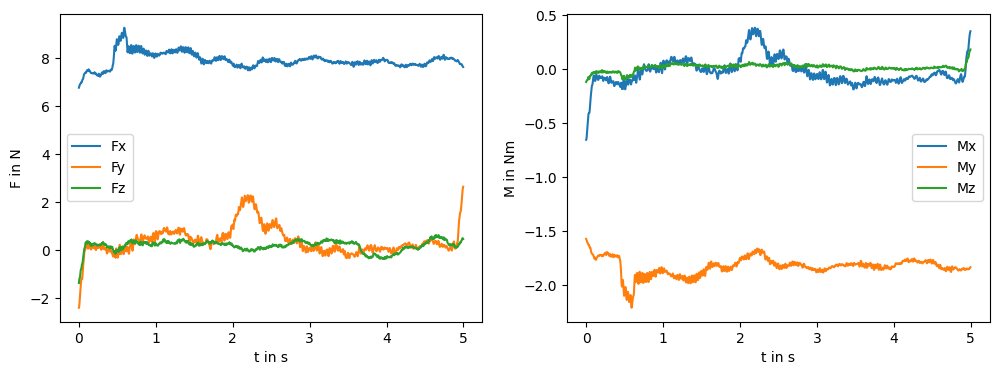

In [65]:
# Gleitender Mittelwert um Rohdaten für das Plotten zu glätten
def moving_average(x, N: int):
    """Gleitender Mittelwert von x über N Werte."""
    x = np.pad(x, int(N/2), mode='edge')
    x = np.convolve(x, np.ones(N), 'same') / N
    x = x[int(N/2):-int(N/2)]
    return x

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

# Lösung einfügen...
ax1.plot(t, moving_average(Fxyz[:, 0], 50), label="Fx")
ax1.plot(t, moving_average(Fxyz[:, 1], 50), label="Fy")
ax1.plot(t, moving_average(Fxyz[:, 2], 50), label="Fz")
ax1.legend()
ax1.set_xlabel("t in s")
ax1.set_ylabel("F in N")

ax2.plot(t, moving_average(Mxyz[:, 0], 50), label="Mx")
ax2.plot(t, moving_average(Mxyz[:, 1], 50), label="My")
ax2.plot(t, moving_average(Mxyz[:, 2], 50), label="Mz")
ax2.legend()
ax2.set_xlabel("t in s")
ax2.set_ylabel("M in Nm")

plt.show()

### Berechnung des Strömungswiderstandskoeffizienten $c_w$

Im allgemeinen gilt folgender Zusammenhang für den Luftwiderstand $F_w$:
$$F_w = \frac{1}{2} c_w \rho \, v^2 A$$

Dabei ist $\rho$ die Dichte der Luft (konstant angenommen zu $\rho = 1.225 \, \frac{\mathrm{kg}}{\mathrm{m^3}}$), $v$ die Windgeschwindigkeit und $A$ die Stirnfläche des Motorrads.

Diese Gleichung kann nun nach $c_w$ umgestellt werden:
$$c_w = \frac{2 F_w}{\rho \, v^2 A}$$

Zu beachten gilt nun, welche der transformierten, gemessenen Kräfte $F_x$, $F_y$ und $F_z$ in der obigen Gleichung für $F_w$ eingesetzt werden müssen. Weiters soll hierfür jeweils der Mittelwert über den Messzeitraum verwendet werden.

In [66]:
rho = 1.225 #in kg/m^3
v = 60/3.6 #in m/s
A = 0.0876 #in m^2

# Lösung einfügen...
F_w = np.mean(Fxyz[:, 0])
c_w = (2*F_w) / (rho*(v**2)*A)


print(F"Der Luftwiderstand bei v={v:.3f} m/s beträgt im Mittel F_w={F_w:.3f} N")
print(F"Der daraus resultierende Strömungswiderstandskoeffizient beträgt c_w={c_w:.3f}")

Der Luftwiderstand bei v=16.667 m/s beträgt im Mittel F_w=7.926 N
Der daraus resultierende Strömungswiderstandskoeffizient beträgt c_w=0.532


### Visualisierung des Luftwiderstandes $F_w$ in Abhängigkeit der Geschwindigkeit von 0 km/h bis 100 km/h

Um ein Gefühl für das weitere Verhalten des Modells zu bekommen soll der Luftwiderstand $F_w$ in Abhängigkeit der Geschwindigkeit $v$ visualisiert werden.

Text(0, 0.5, 'F_w in N')

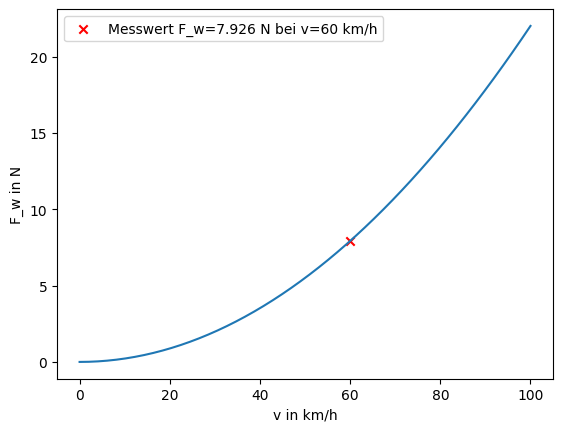

In [67]:
# Lösung einfügen...
ax = plt.subplot()
v = 60 #in hm/h
F_w = (1/2)*c_w*rho*((v/3.6)**2)*A
ax.scatter(v, F_w, color="red" ,marker="x", label=F"Messwert F_w={F_w:.3f} N bei v={v} km/h")
ax.legend()

v = np.linspace(0, 100)
F_w = (1/2)*c_w*rho*((v/3.6)**2)*A
ax.plot(v, F_w)

ax.set_xlabel("v in km/h")
ax.set_ylabel("F_w in N")